In [5]:
import sys; sys.path.append("../") # For relative imports

import glob
import os
import pickle

from utils.conformal_utils import *
from utils.experiment_utils import get_inputs_folder, get_outputs_folder, get_figs_folder

plt.rcParams.update({
    'font.size': 16,        # base font size
    'axes.titlesize': 18,   # subplot titles
    'axes.labelsize': 16,   # x/y labels
    'legend.fontsize': 16,  # legend text
    'xtick.labelsize': 16,  # tick labels
    'ytick.labelsize': 16,

})
# use tex with matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

dataset_names = {
    "plantnet": "Pl@ntNet-300K",
    "inaturalist": "iNaturalist",
    "plantnet-trunc": "Pl@ntNet-300K (truncated)",
    "inaturalist-trunc": "iNaturalist (truncated)",
}


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
## Choose dataset to create figures for
# dataset = 'plantnet'
# dataset = 'plantnet-trunc'
dataset = 'inaturalist'
# dataset = 'inaturalist-trunc'

methods = ['standard', 'classwise', 'classwise-exact', 'clustered', 'prevalence-adjusted'] + \
            [f'fuzzy-rarity-{bw}' for bw in [1e-16, 1e-12, 1e-8, 1e-6, 0.0001, 0.001, 0.01, .1 , 10, 1000]] +\
            [f'fuzzy-RErarity-{bw}' for bw in [1e-16, 1e-12, 1e-8, 1e-6, 0.0001, 0.001, 0.01, .1 , 10, 1000]] +\
            [f'fuzzy-READDrarity-{bw}' for bw in [1e-16, 1e-12, 1e-8, 1e-6, 0.0001, 0.001, 0.01, .1 , 10, 1000]] +\
            [f'cvx-cw_weight={w}' for w in 1 - np.array([0, .001, .01, .025, .05, .1, .15, .2, .4, .6, .8, 1])] +\
            [f'monotonic-cvx-cw_weight={w}' for w in 1 - np.array([0, .001, .01, .025, .05, .1, .15, .2, .4, .6, .8, 1])]


alphas = [0.2, 0.1, 0.05, 0.01]

score = 'softmax'

# Load in paths from folders.json
results_folder = get_outputs_folder()
fig_folder = get_figs_folder()

os.makedirs(f'{fig_folder}/{dataset}', exist_ok=True)

In [17]:
# Load test labels
test_labels = np.load(f'/home-warm/plantnet/conformal_cache/train_models/best-{dataset}-model_test_labels.npy')
num_classes = np.max(test_labels) + 1

In [18]:
%%time

# Load metrics

def load_metrics(dataset, alpha, method_name, score='softmax'):
    with open(f'{results_folder}/{dataset}_{score}_alpha={alpha}_{method_name}.pkl', 'rb') as f:
        metrics = pickle.load(f)
    # Extract set size quantiles for easy access later
    metrics['set_size_metrics']['median'] = metrics['set_size_metrics']['[.25, .5, .75, .9] quantiles'][1]
    metrics['set_size_metrics']['quantile90'] = metrics['set_size_metrics']['[.25, .5, .75, .9] quantiles'][3]
    return metrics


all_res = {}

for alpha in alphas:
    res = {}
    for method in methods:
        # print(method)
        res[method] = load_metrics(dataset, alpha, method)
    all_res[f'alpha={alpha}'] = res

CPU times: user 33.1 ms, sys: 103 ms, total: 136 ms
Wall time: 1.03 s


In [19]:
def compute_class_cond_decision_accuracy(labels, is_covered, raw_set_sizes):
    # (assuming a random decision maker)
    num_classes = np.max(labels) + 1
    decision_acc = np.zeros((num_classes,))
    for k in range(num_classes):
        idx = labels == k
        # P(choose correct label) = 0 if label not in set
        # P(choose correct label) = 1/(set size) if label in set
        p_correct = is_covered[idx] * (1/raw_set_sizes[idx])
        p_correct[np.isnan(p_correct)] = 0 # nans are due to empty sets, so replace with 0
        decision_acc[k] = np.mean(p_correct)
        if np.isnan(decision_acc[k]):
            pdb.set_trace()

    return decision_acc

def compute_class_cond_decision_accuracy_for_method(res, method, labels):
    is_covered = res[method]['coverage_metrics']['is_covered']
    raw_set_sizes = res[method]['coverage_metrics']['raw_set_sizes']
    
    return compute_class_cond_decision_accuracy(labels, is_covered, raw_set_sizes)


In [20]:
# Add class-conditional decision accuracies to metrics
for res in all_res.values():
    for method in methods:
        dec_acc = compute_class_cond_decision_accuracy_for_method(res, method, test_labels)
        res[method]['class-cond-decision-accuracy'] = dec_acc

/tmp/ipykernel_4092750/1574305551.py:9: RuntimeWarning: divide by zero encountered in divide
  p_correct = is_covered[idx] * (1/raw_set_sizes[idx])
/tmp/ipykernel_4092750/1574305551.py:9: RuntimeWarning: invalid value encountered in multiply
  p_correct = is_covered[idx] * (1/raw_set_sizes[idx])


Saved plot to /home/tding/code/clean/long-tail-conformal/figs/inaturalist/inaturalist_softmax_fuzzy-RErarity-0.0001_decision-acc.pdf
Saved plot to /home/tding/code/clean/long-tail-conformal/figs/inaturalist/inaturalist_softmax_fuzzy-RErarity-0.0001_decision-acc_WITH_LEGEND.pdf
Saved plot to /home/tding/code/clean/long-tail-conformal/figs/inaturalist/inaturalist_softmax_prevalence-adjusted_decision-acc.pdf
Saved plot to /home/tding/code/clean/long-tail-conformal/figs/inaturalist/inaturalist_softmax_prevalence-adjusted_decision-acc_WITH_LEGEND.pdf
Saved plot to /home/tding/code/clean/long-tail-conformal/figs/inaturalist/inaturalist_softmax_cvx-cw_weight=0.99_decision-acc.pdf
Saved plot to /home/tding/code/clean/long-tail-conformal/figs/inaturalist/inaturalist_softmax_cvx-cw_weight=0.99_decision-acc_WITH_LEGEND.pdf


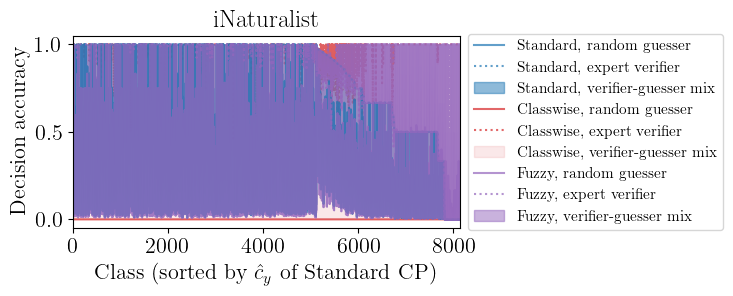

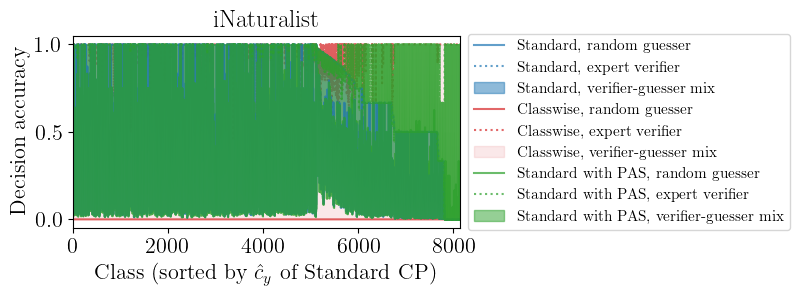

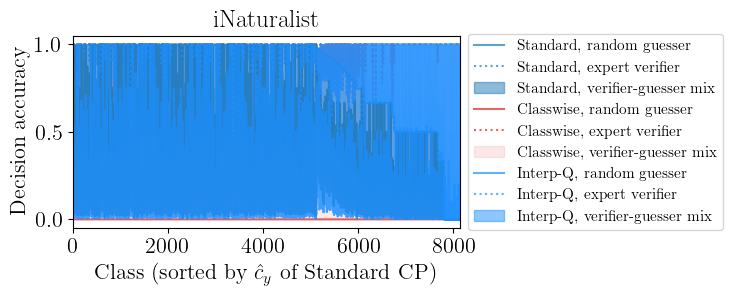

In [21]:
def make_decision_acc_plot(res, method, color):

    # Sort classes by decision accuracy of Standard CP
    # idx = np.argsort(res['standard']['class-cond-decision-accuracy'])
    
    # Sort classes by class cond acc of Standard CP
    idx = np.argsort(res['standard']['coverage_metrics']['raw_class_coverages'])[::-1]
    
    # # # Sort classes by train prevalence
    # train_labels_path = f'/home-warm/plantnet/conformal_cache/train_models/{dataset}_train_labels.npy'
    # train_labels = np.load(train_labels_path)
    # train_class_distr = np.array([np.sum(train_labels == k) for k in range(num_classes)]) / len(train_labels) 
    # idx = np.argsort(train_class_distr)
    
    # fig, ax = plt.subplots(figsize=(10,2.5))
    fig, ax = plt.subplots(figsize=(5,2.5))
    
    method_to_name = {'standard': 'Standard', 
                      'classwise': 'Classwise', 
                      'fuzzy-RErarity-0.0001': 'Fuzzy',
                      'prevalence-adjusted': 'Standard with PAS',
                      'cvx-cw_weight=0.99': 'Interp-Q'}
    
    # for method, color in zip(['standard', 'classwise', 'fuzzy-RErarity-0.0001', 'prevalence-adjusted'],
    #                          ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']):
    for method, color in zip(['standard', 'classwise', method],
                             ['tab:blue', 'tab:red', color]):
    # for method, color in zip(['standard', 'classwise', 'prevalence-adjusted'],
    #                          ['tab:blue', 'tab:red', 'tab:green']):    
        # fig, ax = plt.subplots(figsize=(9,1))
    
        if method == 'classwise':
            zorder = 0
            alpha = 0.1
        else:
            zorder = 2
            alpha = 0.5

        ax.plot(res[method]['class-cond-decision-accuracy'][idx], color=color, alpha=0.7, zorder=zorder,
               label=f'{method_to_name[method]}, random guesser')
        ax.plot(res[method]['coverage_metrics']['raw_class_coverages'][idx], color=color, alpha=0.7, 
                linestyle = ':',
                zorder=zorder, label=f'{method_to_name[method]}, expert verifier')
    
        ax.fill_between(np.arange(num_classes), 
                         y1=res[method]['class-cond-decision-accuracy'][idx],
                         y2=res[method]['coverage_metrics']['raw_class_coverages'][idx], 
                         label=f'{method_to_name[method]}, verifier-guesser mix',
                         color=color, alpha=alpha)
        # ax.set_title(method)
        
        ax.set_xlim(0, num_classes-1)
        ax.set_ylabel('Decision accuracy')
        # ax.set_xlabel('Class (sorted by rand decision acc of Standard CP)')
        ax.set_xlabel('Class (sorted by $\\hat{c}_y$ of Standard CP)')
        # ax.set_xlabel('Class (sorted by train prevalence)')

        ax.set_title(dataset_names[dataset])
    
    fig_path = f'{fig_folder}/{dataset}/{dataset}_{score}_{method}_decision-acc.pdf'
    
    
    # Save 
    plt.savefig(fig_path, bbox_inches='tight')
    print('Saved plot to', fig_path)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1.05), fontsize=11)
    new_path = fig_path.replace('.pdf', '_WITH_LEGEND.pdf')
    plt.savefig(new_path, bbox_inches='tight')
    print('Saved plot to', new_path)

# Plot for alpha = 0.1
res = all_res['alpha=0.1']

method = 'fuzzy-RErarity-0.0001'
color = 'tab:purple'
make_decision_acc_plot(res, method, color)

method = 'prevalence-adjusted'
color = 'tab:green'
make_decision_acc_plot(res, method, color)

method = 'cvx-cw_weight=0.99'
color = 'dodgerblue'
make_decision_acc_plot(res, method, color)

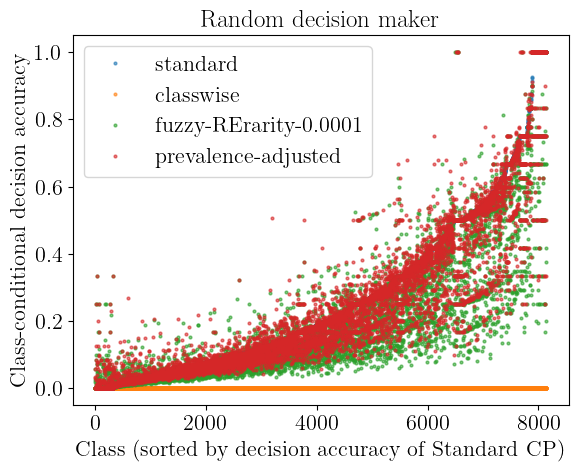

In [22]:
# Plot for alpha = 0.1
res = all_res['alpha=0.1']

# # Sort classes by train prevalence
# train_labels_path = f'/home-warm/plantnet/conformal_cache/train_models/{dataset}_train_labels.npy'
# train_labels = np.load(train_labels_path)
# train_class_distr = np.array([np.sum(train_labels == k) for k in range(num_classes)]) / len(train_labels) 
# idx = np.argsort(train_class_distr)

# Sort classes by decision accuracy of Standard CP
idx = np.argsort(res['standard']['class-cond-decision-accuracy'])

# for method in methods:
for method in ['standard', 'classwise', 'fuzzy-RErarity-0.0001', 'prevalence-adjusted']:
    plt.plot(res[method]['class-cond-decision-accuracy'][idx], 'o', markersize=2, label=method, alpha=0.6)

# metric = 'class-cond-decision-accuracy'
# plt.figure(figsize=(10,3))
# plt.plot(res['standard'][metric][idx], label='standard', alpha=1, zorder=10)
# plt.plot(res['classwise'][metric][idx], label='classwise', alpha=1)
# plt.plot(res['fuzzy-RErarity-0.001'][metric][idx], # 'o', markersize=2,
#          label='fuzzy-RErarity-0.001', alpha=0.6)
# plt.plot(res['prevalence-adjusted'][metric][idx], 'o', markersize=2,
#          label='prevalence-adjusted', alpha=0.6)

plt.ylabel('Class-conditional decision accuracy')
plt.xlabel('Class (sorted by decision accuracy of Standard CP)')
plt.title('Random decision maker')
plt.legend()
plt.show()

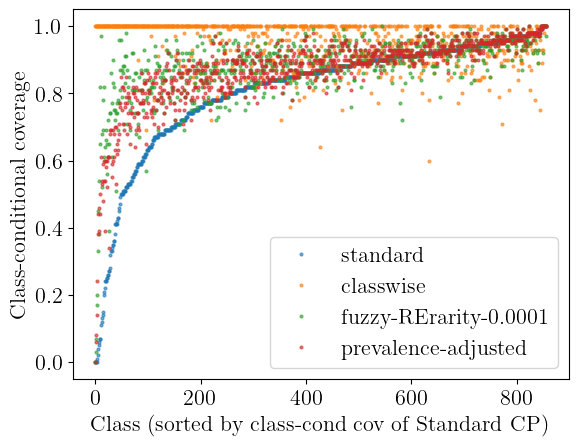

In [13]:
# Plot for alpha = 0.1
res = all_res['alpha=0.1']

# Sort classes by class cond coverage of Standard CP
idx = np.argsort(res['standard']['coverage_metrics']['raw_class_coverages'])

# for method in methods:
for method in ['standard', 'classwise', 'fuzzy-RErarity-0.0001', 'prevalence-adjusted']:
    plt.plot(res[method]['coverage_metrics']['raw_class_coverages'][idx], 'o', markersize=2,
             label=method, alpha=0.6)

# metric = 'raw_class_coverages'
# plt.figure(figsize=(10,3))
# plt.plot(res['standard']['coverage_metrics'][metric][idx], label='standard', alpha=1, zorder=10)
# plt.plot(res['classwise']['coverage_metrics'][metric][idx], label='classwise', alpha=1)
# plt.plot(res['fuzzy-RErarity-0.001']['coverage_metrics'][metric][idx], # 'o', markersize=2,
#          label='fuzzy-RErarity-0.001', alpha=0.6)
# plt.plot(res['prevalence-adjusted']['coverage_metrics'][metric][idx], 'o', markersize=2,
#          label='prevalence-adjusted', alpha=0.6)

plt.ylabel('Class-conditional coverage')
plt.xlabel('Class (sorted by class-cond cov of Standard CP)')
plt.legend()
plt.show()

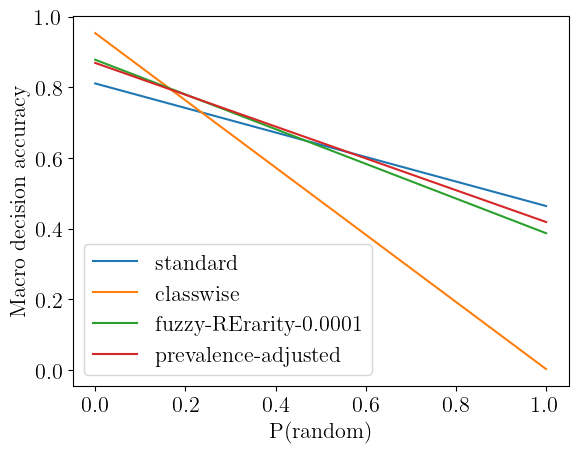

In [14]:
# Macro decision accuracy

# Plot for alpha = 0.1
res = all_res['alpha=0.1']

p_rands = np.linspace(0,1,11) # P(random decision maker)

for method in ['standard', 'classwise', 'fuzzy-RErarity-0.0001', 'prevalence-adjusted']:
    decision_accs = np.zeros(p_rands.shape)
    for i, p_rand in enumerate(p_rands):
        acc_random = res[method]['class-cond-decision-accuracy']
        acc_discerning = res[method]['coverage_metrics']['raw_class_coverages']
        decision_accs[i] = np.mean(p_rand * acc_random + (1-p_rand) * acc_discerning)
    plt.plot(p_rands, decision_accs, label=method)

plt.xlabel('P(random)')
plt.ylabel('Macro decision accuracy')
plt.legend()
plt.show()
    

In [23]:
# res.keys()